In [1]:
import pandas as pd
import os

In [2]:
def read_space_separated_csv(file_path, column_names, delim = '\t'):
    return pd.read_csv(file_path, sep=delim, names=column_names)

In [3]:
def process_poi_data(poi_data_str):
    poi_data_dict = {}
    for pair in poi_data_str.split('\t'):
        key, value = pair.split(':')
        poi_data_dict[key] = int(value)
    return poi_data_dict


In [4]:
def read_poi_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().split('\n')

    data = []

    for line in lines:
        if line:
            region_hash, poi_data_str = line.split('\t', 1)
            poi_data_dict = process_poi_data(poi_data_str)
            data.append({'region_hash': region_hash, 'poi_data': poi_data_dict})

    column_names = ['region_hash', 'poi_data']
    poi_data_df = pd.DataFrame(data, columns=column_names)
    return poi_data_df


In [5]:
file_path = 'training_data/poi_data/poi_data'
poi_data = read_poi_data(file_path)

In [6]:
# Read the cluster map data
cluster_map_columns = ['region_hash', 'region_id']
cluster_map_file_path = 'training_data/cluster_map/cluster_map'
cluster_map = read_space_separated_csv(cluster_map_file_path, cluster_map_columns)

In [7]:
# Read the order data files
order_data_columns = ['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'Price', 'Time']
order_data_folder_path = 'training_data/order_data/'
order_data_files = [f for f in os.listdir(order_data_folder_path) if os.path.isfile(os.path.join(order_data_folder_path, f)) and not f.startswith('._')]
order_data_list = [read_space_separated_csv(os.path.join(order_data_folder_path, file), order_data_columns) for file in order_data_files]
order_data = pd.concat(order_data_list)

In [8]:
# Read the weather data files
weather_data_columns = ['Time', 'Weather', 'temperature', 'PM2.5']
weather_data_folder_path = 'training_data/weather_data/'
weather_data_files = [f for f in os.listdir(weather_data_folder_path) if os.path.isfile(os.path.join(weather_data_folder_path, f)) and not f.startswith('._')]
weather_data_list = [read_space_separated_csv(os.path.join(weather_data_folder_path, file), weather_data_columns) for file in weather_data_files]
weather_data = pd.concat(weather_data_list)

In [9]:
# print(weather_data.head(1))
# print(order_data.head(1))
# print(cluster_map.head(2))

def count_facilities(poi_data_dict):
    return sum(poi_data_dict.values())

poi_data['total_facilities'] = poi_data['poi_data'].apply(count_facilities)
print(poi_data.head(1))


                        region_hash  \
0  74c1c25f4b283fa74a5514307b0d0278   

                                            poi_data  total_facilities  
0  {'1#11': 2241, '1#10': 249, '24': 1245, '25': ...            878555  


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [11]:
# Convert the 'Time' column to datetime format
order_data['Time'] = pd.to_datetime(order_data['Time'])
weather_data['Time'] = pd.to_datetime(weather_data['Time'])

order_data['Time'] = order_data['Time'].dt.round('10min')
weather_data['Time'] = weather_data['Time'].dt.round('10min')

In [12]:
# Sort the datasets by time
order_data = order_data.sort_values('Time')
weather_data = weather_data.sort_values('Time')

In [13]:
# Merge the cluster_map into the order_data
order_data = order_data.merge(cluster_map, left_on='start_region_hash', right_on='region_hash', how='left')
order_data = order_data.rename(columns={'region_id': 'start_region_id'}).drop('region_hash', axis=1)

order_data = order_data.merge(cluster_map, left_on='dest_region_hash', right_on='region_hash', how='left')
order_data = order_data.rename(columns={'region_id': 'dest_region_id'}).drop('region_hash', axis=1)
order_data = order_data.merge(weather_data, on='Time', how='left')
order_data = order_data.merge(poi_data, left_on='start_region_hash', right_on='region_hash', how='left')

In [14]:
# Calculate the demand and supply columns
order_data['demand'] = 1
order_data['supply'] = order_data['driver_id'].notnull().astype(int)

In [15]:
# Aggregate data by time slot and region
grouped_data = order_data.groupby([pd.Grouper(key='Time', freq='10min'), 'start_region_id']).agg({
    'demand': 'sum',
    'supply': 'sum',
    'Weather': 'mean',
    'temperature': 'mean',
    'PM2.5': 'mean',
    'total_facilities': 'sum'
}).reset_index()


grouped_data['gap'] = grouped_data['demand'] - grouped_data['supply']

print(grouped_data.head(3))

        Time  start_region_id  demand  supply  Weather  temperature  PM2.5  \
0 2016-01-01                1      64      60      1.0          4.0  177.0   
1 2016-01-01                2       1       1      1.0          4.0  177.0   
2 2016-01-01                3       2       1      1.0          4.0  177.0   

   total_facilities  gap  
0          41816064    4  
1            343537    0  
2             62250    1  


In [16]:
# Prepare the features and target variable
X = grouped_data.drop(['Time', 'gap', 'demand', 'supply'], axis=1)
X = X[['start_region_id', 'Weather', 'temperature', 'PM2.5', 'total_facilities']]
y = grouped_data['gap']

In [17]:
# Encode the region id column
train_df = X.copy()
train_df['predicted_gap'] = grouped_data['gap']

X['start_region_id'] = LabelEncoder().fit_transform(X['start_region_id'])

In [18]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# Prepare the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
# Create a dictionary of hyperparameters to tune
param_dist = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
}

In [21]:
# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [22]:
# Initialize the RandomizedSearchCV with a 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1, random_state=42)

In [23]:
# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [24]:
# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [25]:
# Train the XGBoost model with the best hyperparameters
best_xgb_reg = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [26]:
# Predict the demand-supply gap for the testing dataset
y_pred = best_xgb_reg.predict(X_test)

In [27]:
# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

Mean Squared Error: 693.6450716687801
R-squared: 0.9234986551242398
Mean Absolute Error: 8.10977431845886


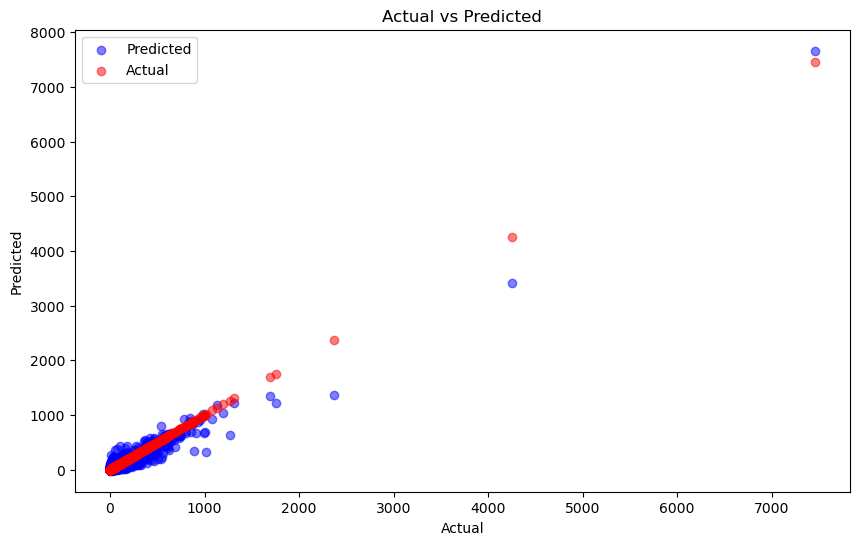

In [28]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='blue', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.5, c='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()


In [29]:
# storing data for the next model
test_poi_data_file_path = 'test_set/poi_data/poi_data'
test_poi_data = read_poi_data(test_poi_data_file_path)

test_cluster_map_file_path = 'test_set/cluster_map/cluster_map'
test_cluster_map = read_space_separated_csv(test_cluster_map_file_path, cluster_map_columns)

order_data_columns = ['order_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'Time']
test_order_data_folder_path = 'test_set/order_data/'
test_order_data_files = [f for f in os.listdir(test_order_data_folder_path) if os.path.isfile(os.path.join(test_order_data_folder_path, f)) and not f.startswith('._')]
test_order_data_list = [read_space_separated_csv(os.path.join(test_order_data_folder_path, file), order_data_columns, ',') for file in test_order_data_files]
test_order_data = pd.concat(test_order_data_list)

test_weather_data_folder_path = 'test_set/weather_data/'
test_weather_data_files = [f for f in os.listdir(test_weather_data_folder_path) if os.path.isfile(os.path.join(test_weather_data_folder_path, f)) and not f.startswith('._')]
test_weather_data_list = [read_space_separated_csv(os.path.join(test_weather_data_folder_path, file), weather_data_columns) for file in test_weather_data_files]
test_weather_data = pd.concat(test_weather_data_list)

test_poi_data['total_facilities'] = test_poi_data['poi_data'].apply(count_facilities)


In [30]:
# Convert the 'Time' column to datetime format
test_order_data['Time'] = pd.to_datetime(test_order_data['Time'])
test_weather_data['Time'] = pd.to_datetime(test_weather_data['Time'])

test_order_data['Time'] = test_order_data['Time'].dt.round('10min')
test_weather_data['Time'] = test_weather_data['Time'].dt.round('10min')

In [31]:
# Sort the datasets by time
test_order_data = test_order_data.sort_values('Time')
test_weather_data = test_weather_data.sort_values('Time')

In [32]:
# Merge the cluster_map into the test_order_data
test_order_data = test_order_data.merge(test_cluster_map, left_on='start_region_hash', right_on='region_hash', how='left')
test_order_data = test_order_data.rename(columns={'region_id': 'start_region_id'}).drop('region_hash', axis=1)

test_order_data = test_order_data.merge(test_cluster_map, left_on='dest_region_hash', right_on='region_hash', how='left')
test_order_data = test_order_data.rename(columns={'region_id': 'dest_region_id'}).drop('region_hash', axis=1)
test_order_data = test_order_data.merge(test_weather_data, on='Time', how='left')
test_order_data = test_order_data.merge(test_poi_data, left_on='start_region_hash', right_on='region_hash', how='left')

In [33]:
# Calculate the demand for the test dataset
test_order_data['demand'] = 1

In [34]:
# Aggregate data by time slot and region
test_grouped_data = test_order_data.groupby([pd.Grouper(key='Time', freq='10min'), 'start_region_id']).agg({
    'demand': 'sum',
    'Weather': 'mean',
    'temperature': 'mean',
    'PM2.5': 'mean',
    'total_facilities': 'sum'
}).reset_index()

In [35]:
# Prepare the features
test_X = test_grouped_data.drop(['Time'], axis=1)
test_X = test_X[['start_region_id', 'Weather', 'temperature', 'PM2.5', 'total_facilities']]

In [36]:
# Encode the region_id column
test_X['start_region_id'] = LabelEncoder().fit_transform(test_X['start_region_id'])

In [37]:
# Predict the demand-supply gap for the testing dataset
test_y_pred = best_xgb_reg.predict(test_X)

test_df = test_X.copy()
test_df['predicted_gap'] = test_y_pred

In [38]:
import numpy as np
from scipy.spatial import KDTree

train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

train_X_array = train_df.drop('predicted_gap', axis=1).to_numpy()
test_X_array = test_df.drop('predicted_gap', axis=1).to_numpy()



In [39]:
import numpy as np
import pandas as pd

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

In [40]:
def find_similar_rows(train_df, test_df, threshold, gap_tolerance):
    similar_rows = []
    train_data = train_df.drop(columns='predicted_gap').values
    test_data = test_df.drop(columns='predicted_gap').values

    for test_index, test_row in enumerate(test_data):
        distances = euclidean_distance(train_data, test_row)
        min_distance_index = distances.argmin()
        min_distance = distances[min_distance_index]

        test_gap = test_df.loc[test_index, 'predicted_gap']
        train_gap = train_df.loc[min_distance_index, 'predicted_gap']
        gap_diff = abs(test_gap - train_gap)
        if min_distance <= threshold and gap_diff <= gap_tolerance:
            similar_rows.append({
                'test_row_index': test_index,
                'train_row_index': min_distance_index,
                'test_predicted_gap': test_gap,
                'train_predicted_gap': train_gap,
                'euclidean_distance': min_distance
            })

    return pd.DataFrame(similar_rows)

In [41]:
threshold = 5
gap_tolerance = 5  # Adjust this value as needed
matching_rows = find_similar_rows(train_df, test_df, threshold, gap_tolerance)
matching_rows = matching_rows.sort_values(by=['euclidean_distance'])
print(matching_rows)


      test_row_index  train_row_index  test_predicted_gap  \
3492            7546            88093            0.518004   
3649            7815            88245            0.214770   
1490            3394           162355            0.849214   
1493            3400           162424            0.632056   
3648            7814            88244            0.199345   
...              ...              ...                 ...   
748             1596           162025           10.634451   
750             1608           162036            1.749175   
2781            6092           123731            1.165518   
2130            4901           133934            3.793637   
11                29           131559            1.437764   

      train_predicted_gap  euclidean_distance  
3492                    0                 1.0  
3649                    2                 1.0  
1490                    1                 1.0  
1493                    0                 1.0  
3648                    0  

In [42]:
import pandas as pd
import os

def read_space_separated_csv(file_path, column_names, delim = '\t'):
    return pd.read_csv(file_path, sep=delim, names=column_names)

def process_poi_data(poi_data_str):
    poi_data_dict = {}
    for pair in poi_data_str.split('\t'):
        key, value = pair.split(':')
        poi_data_dict[key] = int(value)
    return poi_data_dict

def read_poi_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().split('\n')

    data = []

    for line in lines:
        if line:
            region_hash, poi_data_str = line.split('\t', 1)
            poi_data_dict = process_poi_data(poi_data_str)
            data.append({'region_hash': region_hash, 'poi_data': poi_data_dict})

    column_names = ['region_hash', 'poi_data']
    poi_data_df = pd.DataFrame(data, columns=column_names)
    return poi_data_df


file_path = 'training_data/poi_data/poi_data'
poi_data = read_poi_data(file_path)

# Read the cluster_map data
cluster_map_columns = ['region_hash', 'region_id']
cluster_map_file_path = 'training_data/cluster_map/cluster_map'
cluster_map = read_space_separated_csv(cluster_map_file_path, cluster_map_columns)




# Read the order_data files
order_data_columns = ['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'Price', 'Time']
order_data_folder_path = 'training_data/order_data/'
order_data_files = [f for f in os.listdir(order_data_folder_path) if os.path.isfile(os.path.join(order_data_folder_path, f)) and not f.startswith('._')]
order_data_list = [read_space_separated_csv(os.path.join(order_data_folder_path, file), order_data_columns) for file in order_data_files]
order_data = pd.concat(order_data_list)


# Read the weather_data files
weather_data_columns = ['Time', 'Weather', 'temperature', 'PM2.5']
weather_data_folder_path = 'training_data/weather_data/'
weather_data_files = [f for f in os.listdir(weather_data_folder_path) if os.path.isfile(os.path.join(weather_data_folder_path, f)) and not f.startswith('._')]
weather_data_list = [read_space_separated_csv(os.path.join(weather_data_folder_path, file), weather_data_columns) for file in weather_data_files]
weather_data = pd.concat(weather_data_list)

poi_data['total_facilities'] = poi_data['poi_data'].apply(count_facilities)


In [43]:
from sklearn.linear_model import LinearRegression
# Convert the 'Time' column to datetime format
order_data['Time'] = pd.to_datetime(order_data['Time'])
weather_data['Time'] = pd.to_datetime(weather_data['Time'])

order_data['Time'] = order_data['Time'].dt.round('10min')
weather_data['Time'] = weather_data['Time'].dt.round('10min')

In [44]:
# Sort the datasets by time
order_data = order_data.sort_values('Time')
weather_data = weather_data.sort_values('Time')

In [45]:
# Merge the cluster_map into the order_data
order_data = order_data.merge(cluster_map, left_on='start_region_hash', right_on='region_hash', how='left')
order_data = order_data.rename(columns={'region_id': 'start_region_id'}).drop('region_hash', axis=1)

order_data = order_data.merge(cluster_map, left_on='dest_region_hash', right_on='region_hash', how='left')
order_data = order_data.rename(columns={'region_id': 'dest_region_id'}).drop('region_hash', axis=1)
order_data = order_data.merge(weather_data, on='Time', how='left')
order_data = order_data.merge(poi_data, left_on='start_region_hash', right_on='region_hash', how='left')

In [46]:
# Calculate the demand and supply columns
order_data['demand'] = 1
order_data['supply'] = order_data['driver_id'].notnull().astype(int)

In [47]:
# Aggregate data by time slot and region
grouped_data = order_data.groupby([pd.Grouper(key='Time', freq='10min'), 'start_region_id']).agg({
    'demand': 'sum',
    'supply': 'sum',
    'Weather': 'mean',
    'temperature': 'mean',
    'PM2.5': 'mean',
    'total_facilities': 'sum'
}).reset_index()

In [48]:
grouped_data['gap'] = grouped_data['demand'] - grouped_data['supply']
print(grouped_data.head(3))

        Time  start_region_id  demand  supply  Weather  temperature  PM2.5  \
0 2016-01-01                1      64      60      1.0          4.0  177.0   
1 2016-01-01                2       1       1      1.0          4.0  177.0   
2 2016-01-01                3       2       1      1.0          4.0  177.0   

   total_facilities  gap  
0          41816064    4  
1            343537    0  
2             62250    1  


In [49]:
# Prepare the features and target variable
X = grouped_data.drop(['Time', 'gap', 'demand', 'supply'], axis=1)
X = X[['start_region_id', 'Weather', 'temperature', 'PM2.5', 'total_facilities']]

y = grouped_data['gap']

In [50]:
# Encode the region_id column
X['start_region_id'] = LabelEncoder().fit_transform(X['start_region_id'])
X = X.fillna(X.mean())

In [51]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [52]:
# Predict the demand-supply gap for the testing dataset
y_pred = model.predict(X_test)

In [53]:
# Calculate the mean absolute error
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)
linear_mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", linear_mse)
print("R-squared:", linear_r2)
print("Mean Absolute Error:", linear_mae)

Mean Squared Error: 3945.145074789499
R-squared: 0.5648943295664413
Mean Absolute Error: 15.683522685962153


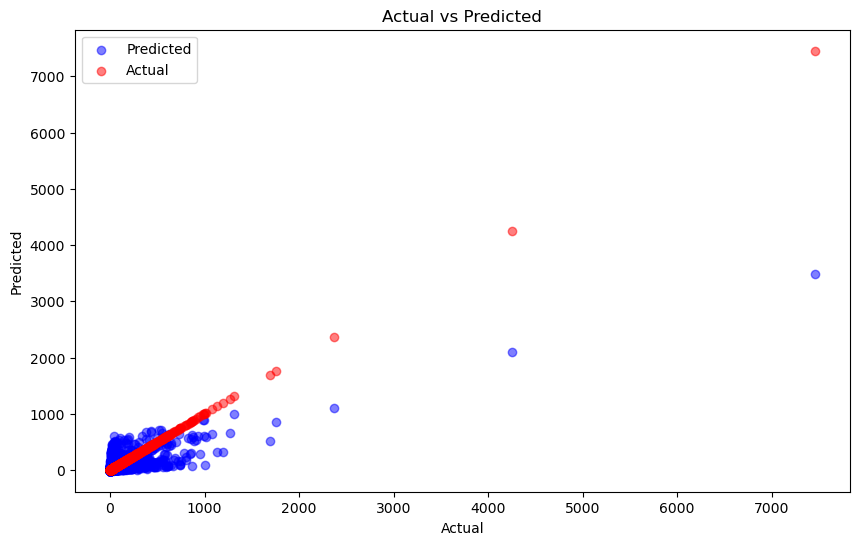

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='blue', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.5, c='red', label='Actual')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()


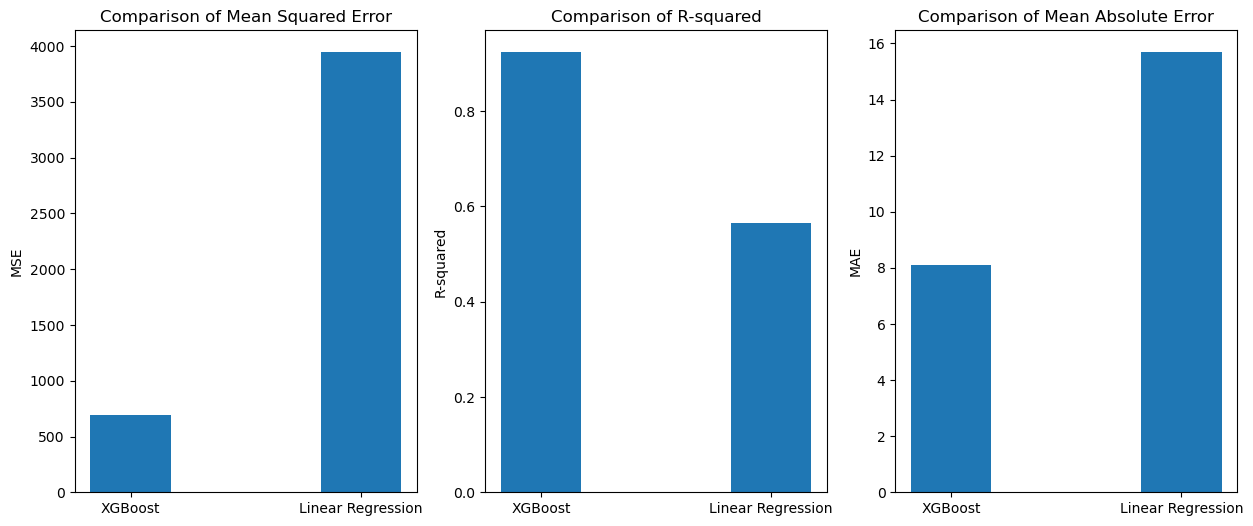

In [57]:
# Bar chart comparison for errors
labels = ['XGBoost', 'Linear Regression']
mse_values = [mse, linear_mse]
r2_values = [r2, linear_r2]
mae_values = [mae, linear_mae]

x = np.arange(len(labels))
width = 0.35

def create_bar_chart(ax, data, ylabel, title):
    rects = ax.bar(x, data, width)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
create_bar_chart(ax1, mse_values, 'MSE', 'Comparison of Mean Squared Error')
create_bar_chart(ax2, r2_values, 'R-squared', 'Comparison of R-squared')
create_bar_chart(ax3, mae_values, 'MAE', 'Comparison of Mean Absolute Error')

plt.show()

## 